In [1]:
import pickle
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
#Load Data
user_df = pickle.load(open('user_data.p','rb'))
transaction_df = pickle.load(open('transaction_data.p','rb'))


### Time Series Analysis:

Analyze volume of venmo transactions grouped by different times. Analyzing transactions during different days of the week. 

In [3]:
transaction_df['date_created_str'] = transaction_df['date_created'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [4]:
#Adding columns with specific time data
transaction_df['weekday'] = transaction_df['date_created_str'].apply(lambda x: x.weekday())
transaction_df['month'] = transaction_df['date_created_str'].apply(lambda x: x.month)
transaction_df['year'] = transaction_df['date_created_str'].apply(lambda x: x.year)
transaction_df['hour'] = transaction_df['date_created_str'].apply(lambda x: x.time().hour)

Text(0, 0.5, 'Percentage of Transactions')

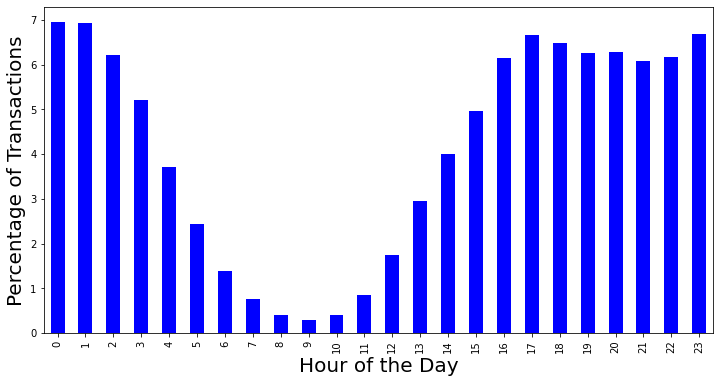

In [5]:
#Plot time of day people use venmo
plt.figure(figsize=(12,6))
(100*transaction_df.groupby('hour').size()/transaction_df.shape[0]).plot.bar(color='b')
plt.xlabel('Hour of the Day',fontsize = 20)
plt.ylabel('Percentage of Transactions',fontsize = 20)

Clear trend with use of Venmo by hour of the day. Primarily after working hours. 

In [10]:
#Dict for x axis on weekday plot
day_dict = {0 : 'Monday',1 : 'Tuesday' ,2 : 'Wednesday',3 : 'Thursday',4: 'Friday',5 : 'Saturday',6: 'Sunday'}
def weekday(x):
    return day_dict[x]
transaction_df['weekday_str'] = transaction_df['weekday'].apply(weekday)
day_order = list(day_dict.values())
day_percent = (100*(transaction_df.groupby('weekday_str').size())/transaction_df.shape[0])

Text(0, 0.5, 'Percentage of Transactions')

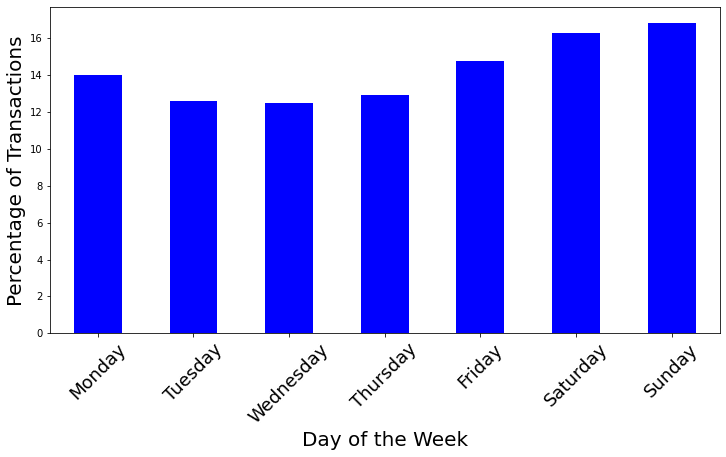

In [11]:
plt.figure(figsize=(12,6))
ax = day_percent.loc[day_order].plot.bar(color='b')
plt.xlabel('Day of the Week',fontsize = 20)
plt.xticks(fontsize = 18, rotation = 45)
plt.ylabel('Percentage of Transactions', fontsize = 20)

Venmo used more on the weekends. 

### Transaction Type:

Categorize each transaction type. Use NLP to clean the data. Then categorize based on stems appearing in notes. 



In [12]:
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stop = stopwords.words('english')
stop = stop + ['skin' , 'face' , 'light'] #adding words commonly found in emojis

In [13]:
#Copy the note column to change and analyze while preserving initial note dota
transaction_df['note_analysis'] = transaction_df['note']

#### Natural Language Processing:

The next cell goes through the cleaning of each transaction note using NLP. The steps are:

-Lower case all words  
-Convert emojis to strings  
-Replace underscores with spaces (mostly for emojis)  
-Strip punctuation  
-Remove stop words, with added stop words commonly found in emojis  
-Stem words

In [14]:
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda x: x.lower())
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda text: " ".join(emoji.demojize(word) for word in text.split()))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda x: x.replace('_',' '))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda x: re.sub('[^\w\s]', '', x))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))
transaction_df['note_analysis'] = transaction_df['note_analysis'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

In [15]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400, collocations=False)
# generate word cloud
wc.generate(' '.join(transaction_df['note_analysis']))

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

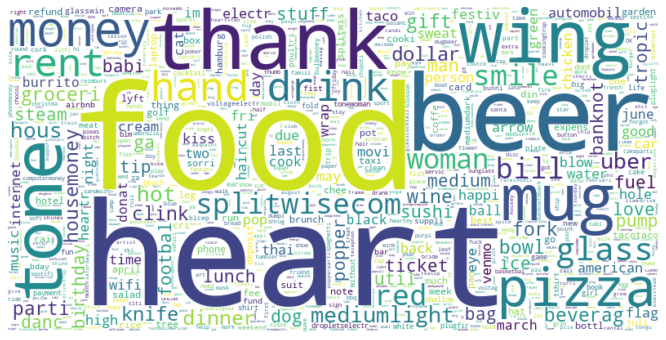

In [17]:
# show
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Categorize

Using the most common words, domain knowledge and close inspection of dataset wrote a naive categorization function. Able to categorize one quarter of transactions using this simple analysis. 

In [18]:
def categorize(note):
    if (re.search('uber|lyft|taxi|cab|automobil',note) != None):
        return 'taxi'
    #Does the word rent or a month appear in the note
    if (re.search(' rent$|^rent$|^rent |groceri|wifi|bill|housemoney|internet|electr',note) != None):
        return 'household'
    if (re.search('airbnb|hotel|airplan|tropic|fuel|toll|beach|ski',note) != None): 
        return 'vacation'        
    if (re.search(' food$|^food$|^food |pizza|thai|taco|brunch|dinner|sushi|lunch|burger|chipotle|coffe|sandwich|breakfast|bread|bagel',note)!= None):
        return 'dining'
    if (re.search('parti|festiv|beer|drink|alcohol|mug|wine|bar|ticket|clink|danc|glasswin|cakeparti',note) != None):
        return 'entertainment'
    return 'unknown'

In [19]:
#Apply the categorize function on the cleaned note column
transaction_df.loc[:,'category'] = transaction_df['note_analysis'].apply(lambda x: categorize(x))

In [20]:
percent_cat = 100*(1-(sum(transaction_df['category'] == 'unknown')/transaction_df.shape[0]))
print(f'{int(percent_cat)}% of transactions categorized')

25% of transactions categorized


In [21]:
#Slice dataframe to only look at data which has been categorized
categories = transaction_df[transaction_df['category'] != 'unknown']

In [22]:
#Colors for the categories
category_colors = {'dining': 'b', 'entertainment': 'r', 'household': 'g','taxi': 'm','vacation': 'c'}

Text(0.5, 0, '')

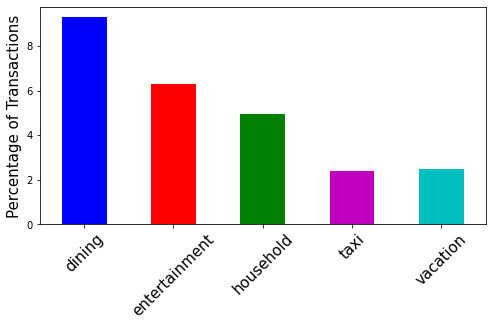

In [23]:

plt.figure(figsize = (8,4))
(100*categories.groupby('category').size()/transaction_df.shape[0]).plot.bar(color=list(category_colors.values()))
plt.ylabel('Percentage of Transactions',fontsize = 15)
plt.xticks(fontsize = 15, rotation = 45)
plt.xlabel(None)

In [25]:
days = categories.groupby(['category','weekday']).size().to_frame().reset_index() 

Text(0, 0.5, 'Percentage of Transactions')

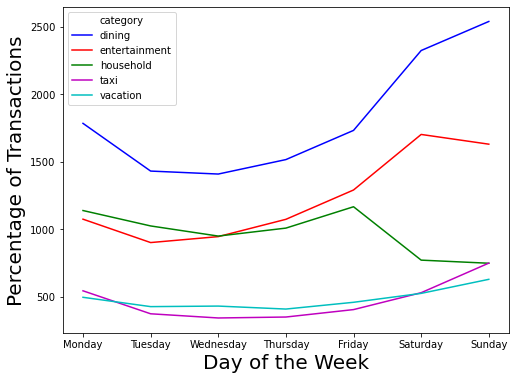

In [26]:
plt.figure(figsize = (8,6))
sns.lineplot(x= 'weekday',y = 0,data = days, hue = 'category', palette = category_colors) #think about normalizing
plt.xlabel('Day of the Week',fontsize = 20)
plt.xticks(range(7),day_order)
plt.ylabel('Percentage of Transactions', fontsize = 20)

### Network Analysis 

Analyze network to rank people with similar spending. Use personalized pagerank to rank nodes similar to given nodes.

In [27]:
import networkx as nx

In [29]:
#Load data from dataframe in to a graph
G_venmo = nx.MultiGraph()
G_venmo.add_nodes_from(user_df['user_id'])
G_venmo.add_edges_from(list(zip(transaction_df['actor_id'], transaction_df['target_id'])))
print('done')

done


In [31]:
#Function which takes input user and graph and outputs that users N closest nodes. N changed with num_friends.
def user_rank(user, G, num_friends = 5):
    personalization = {user : 1}
    page_rank_users = nx.pagerank_scipy(G, personalization = personalization)  
    page_rank_users = {u : v for u,v in sorted(page_rank_users.items(), key=lambda item: item[1], reverse = True)}
    friends = list(page_rank_users)[0:num_friends+1]
    return friends

In [32]:
#Run the analysis on me (Mike Sender)
me = user_df['user_id'][0]
my_close_friends = user_rank(me, G_venmo,6)
near_me = user_rank(me, G_venmo,400)

In [33]:
#Subgraph of the whole graph of my 400 closest nodes
close_network = set(my_close_friends) | set(near_me)
G_close = G_venmo.subgraph(close_network)


In [34]:
pos = nx.spring_layout(G_close)

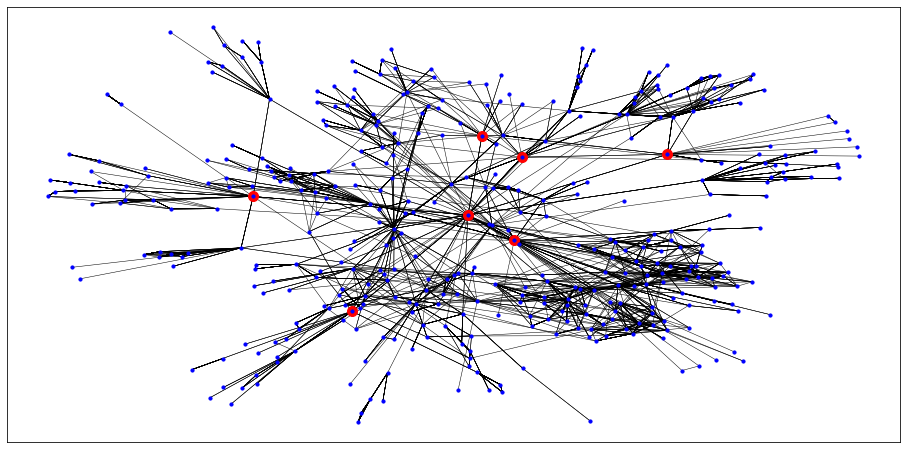

In [36]:

plt.figure(figsize=(16,8), frameon= False)
nx.draw_networkx_nodes(G_close, pos, nodelist = my_close_friends, node_color="r",node_size=100, axis = 'off')
nx.draw_networkx_nodes(G_close, pos, nodelist = near_me, node_color="b",node_size=10, axis= 'off' )
nx.draw_networkx_edges(G_close, pos, edgelist = G_close.edges, width = .5, axis = 'off')


6 highest ranked to me plotted with 400 other nodes

Now do the same analysis starting with Uber and Lyft users. 

In [38]:
uber_df = transaction_df[transaction_df['note_analysis'].str.contains('uber')] #sliced uber dataframe

In [39]:
lyft_df = transaction_df[transaction_df['note_analysis'].str.contains('lyft')] #sliced lyft dataframe

In [40]:
uber_users = set(list(uber_df['actor_id']) + list(uber_df['target_id']))

In [41]:
lyft_users = set(list(lyft_df['actor_id']) + list(lyft_df['target_id']))

In [42]:
#Network of Uber users
prob = 1/len(uber_users)
uber_personalization = {user : prob for user in uber_users}

ranked_uber_network = nx.pagerank_scipy(G_venmo, personalization = uber_personalization)
ranked_uber_network = {u : v for u,v in sorted(ranked_uber_network.items(), key=lambda item: item[1], reverse = True)}
top_uber_users = list(ranked_uber_network)[:3000]

In [43]:
#Net work of Lyft users
prob = 1/len(lyft_users)
lyft_personalization = {user : prob for user in lyft_users}

ranked_lyft_network = nx.pagerank_scipy(G_venmo, personalization = lyft_personalization)
ranked_lyft_network = {u : v for u,v in sorted(ranked_lyft_network.items(), key=lambda item: item[1], reverse = True)}
top_lyft_users = list(ranked_lyft_network)[:3000]

In [44]:
G_ubers_lyfts = G_venmo.subgraph((set(top_uber_users) | set(top_lyft_users)))

In [45]:
uber_lyft_users = set(top_uber_users) & set(top_lyft_users)

In [ ]:
len(uber_lyft_users)/len(set(top_uber_users) | set(top_lyft_users))

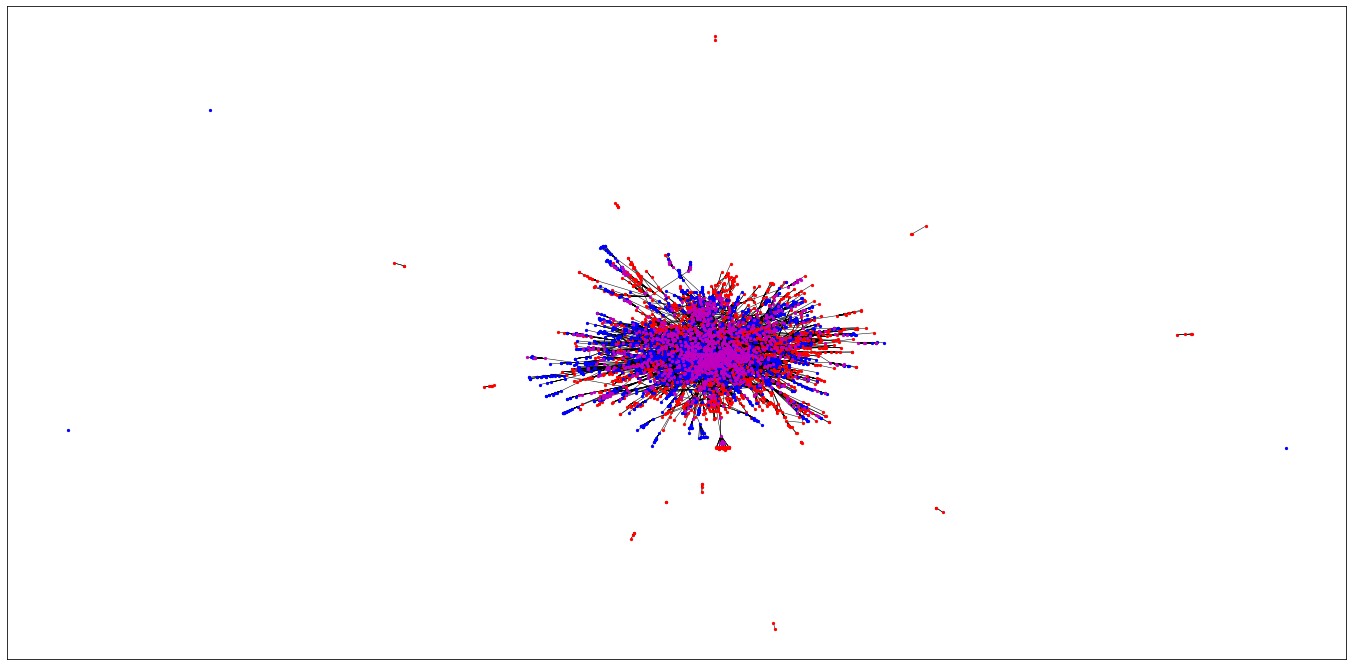

In [46]:
pos = nx.spring_layout(G_ubers_lyfts)
plt.figure(figsize=(24,12))
nx.draw_networkx_nodes(G_ubers_lyfts, pos, nodelist = set(top_uber_users)-uber_lyft_users, node_color="r",node_size=5)
nx.draw_networkx_nodes(G_ubers_lyfts, pos, nodelist = set(top_lyft_users)-uber_lyft_users, node_color="b",node_size=5)
nx.draw_networkx_nodes(G_ubers_lyfts, pos, nodelist = uber_lyft_users, node_color="m",node_size=5)
nx.draw_networkx_edges(G_ubers_lyfts, pos, edgelist = G_ubers_lyfts.edges, width = .5)